## $d=2$ anisotropic convection

$$\Omega = [0, L_x] \times [0, L_y]$$

$$c_0(x,y)=\tfrac{1}{2}\left(1+\text{erf}\left(\frac{y-L_y}{\epsilon}\right)\right)+\mathcal{N}(x,y)$$

$$c(x,y=L_y)=1$$

$$\frac{\partial c}{\partial x}\bigg\vert_{x=0,y}=\frac{\partial c}{\partial x}\bigg\vert_{x=L_x,y}=\frac{\partial c}{\partial y}\bigg\vert_{x,y=0}=0$$

$$\psi\vert_{\partial\Omega}=0$$

$$\textbf{e}_g=-\textbf{e}_y \implies e_g^x=0~,~e_g^y=-1$$

$$
\begin{align*}
\phi &= \phi(\textbf{x}) \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K}(\phi) &= \phi^2\begin{pmatrix}
\cos^2\vartheta +\kappa\sin^2\vartheta & (1 -  \kappa)\cos\vartheta\sin\vartheta \\
(1 -  \kappa)\cos\vartheta\sin\vartheta & \cos^2\vartheta +\kappa\sin^2\vartheta\\
 \end{pmatrix}\\ 
\mu &= 1 \\
\rho(c) &= c
\end{align*}
$$

In [1]:
import numpy as np
import scipy.special as sp
from typing import Callable
from ufl import cos, sin, as_tensor
from lucifex.fdm import FiniteDifference, AB2, CN
from lucifex.fem import LUCiFExConstant as Constant
from lucifex.solver import BoundaryConditions, OptionsPETSc
from lucifex.sim import Simulation, integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, cubic_noise
from lucifex.viz import plot_colormap, create_animation
from lucifex.io import write

from py.porous_convection import create_simulation, create_rectangle_domain


def permeability_cross_bedded(
    Kphi,
    kappa,
    vartheta,
):
    cs = cos(vartheta)
    sn = sin(vartheta)  
    tensor = as_tensor(
        (
            (cs**2 + kappa*sn**2, (1 - kappa)*cs*sn),
            ((1 - kappa)*cs*sn, kappa*cs**2 + sn**2), 
        ),
    )
    return Kphi * tensor


@configure_simulation(
    store_step=1,
    write_step=None,
)
def anisotropic_convection_2d(
    # domain
    Lx: float = 2.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    # physical
    Ra: float = 5e2,
    # porosity and permeability
    porosity: Callable[[np.ndarray], np.ndarray] | float = 1,
    kappa: float = 1.0,
    vartheta: float = 0.0,
    # initial conditions
    erf_eps: float = 1e-2,
    c_eps: float = 1e-6,
    c_freq: tuple[int, int] = (8, 8),
    c_seed: tuple[int, int] = (1234, 5678),
    # time step
    dt_max: float = 0.5,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.75,
    # time discretization
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
    # linear algebra
    psi_petsc: OptionsPETSc | None = None,
    c_petsc: OptionsPETSc | None = None,
    # secondary
    secondary: bool = False,
) -> Simulation:
    Omega, dOmega = create_rectangle_domain(Lx, Ly, Nx, Ny, cell)
    c_bcs = BoundaryConditions(
        ("dirichlet", dOmega['upper'], 1.0),
        ('neumann', dOmega['lower', 'left', 'right'], 0.0)
    )
    c_ics = SpatialPerturbation(
        lambda x: 1 + sp.erf((x[1] - Ly) / erf_eps),
        cubic_noise(['neumann', ('neumann', 'dirichlet')], [Lx, Ly], c_freq, c_seed),
        [Lx, Ly],
        c_eps,
        ) 
    kappa = Constant(Omega, kappa, name='kappa')
    vartheta_rad = vartheta * np.pi / 180
    vartheta = Constant(Omega, vartheta_rad, name='vartheta')
    permeability = lambda phi: permeability_cross_bedded(phi**2, kappa, vartheta)
    density = lambda c: c
    return create_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        Ra=Ra, 
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        porosity=porosity,
        permeability=permeability,
        density=density, 
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv, 
        D_diff=D_diff, 
        psi_petsc=psi_petsc, 
        c_petsc=c_petsc, 
        secondary=secondary,
    )

## Example: isotropic permeability

$$\phi=1$$
$$\kappa = 1$$

In [20]:
simulation_isotropic = anisotropic_convection_2d(
    Lx=2.0,
    Ly=1.0,
    Nx=64,
    Ny=64,
    cell='quadrilateral', 
    Ra=500.0, 
    kappa=1.0,
    c_eps=1e-4, 
    c_freq=(14, 14), 
    c_seed=(456, 987), 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation_isotropic, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

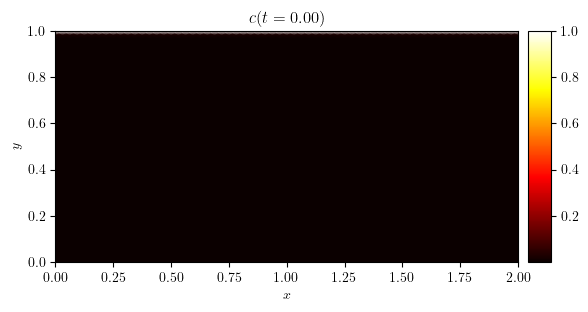

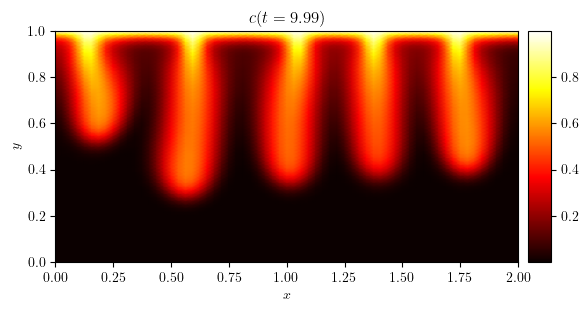

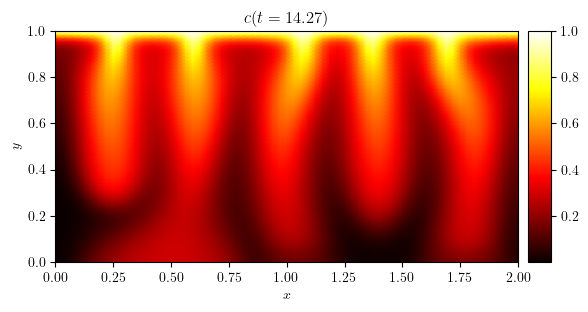

In [ ]:
c = simulation_isotropic['c']

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'$c(t={c.time_series[i]:.2f})$')
    write(fig, f'A12_isotropic_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)

## Example: cross-bedded permeability

$$\phi=1$$
$$\kappa = 0.01$$
$$\vartheta = 45^\circ$$

In [22]:
simulation_crossbed = anisotropic_convection_2d(
    Lx=2.0,
    Ly=1.0,
    Nx=64,
    Ny=64,
    cell='quadrilateral', 
    Ra=500.0, 
    kappa=0.1,
    vartheta=45.0,
    c_eps=1e-4, 
    c_freq=(14, 14), 
    c_seed=(456, 987), 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation_crossbed, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

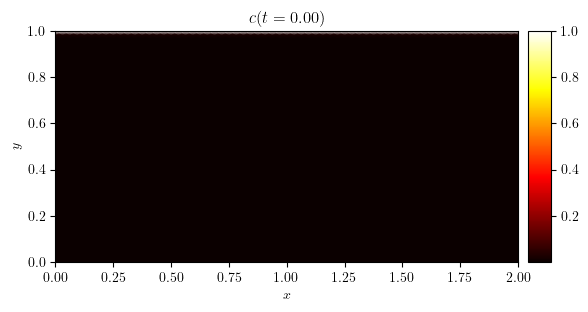

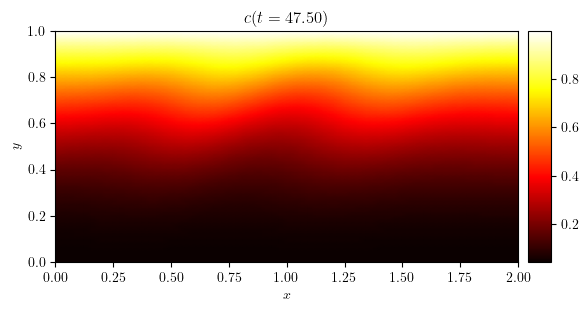

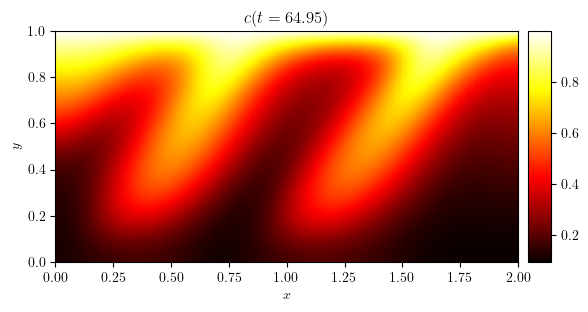

In [ ]:
c = simulation_crossbed['c']

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'$c(t={c.time_series[i]:.2f})$')
    write(fig, f'A12_crossbedded_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)

### Example: low-permeability layer

$$\phi(y)=\begin{cases}
1 & y > h \\
0.1 & \text{otherwise}
\end{cases}$$
$$\kappa = 1$$

In [26]:
Ly = 1.0
k_lower = 0.1
h = 0.5 * Ly
porosity = lambda x: 1 + (k_lower - 1) * (x[1] < h)
simulation_layer = anisotropic_convection_2d(
    Lx=2.0,
    Ly=Ly,
    Nx=64,
    Ny=64,
    cell='quadrilateral', 
    Ra=500.0, 
    porosity=porosity,
    kappa=1.0,
    c_eps=1e-4, 
    c_freq=(14, 14), 
    c_seed=(456, 987), 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation_layer, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

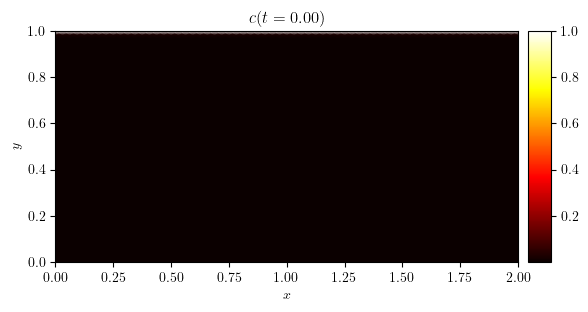

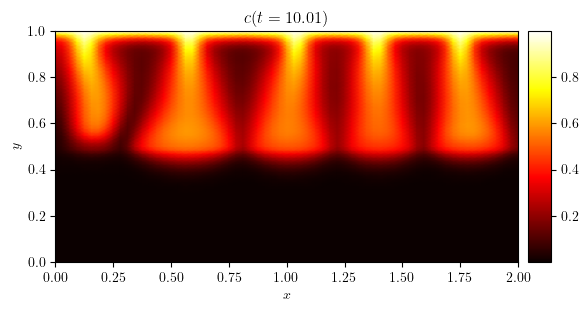

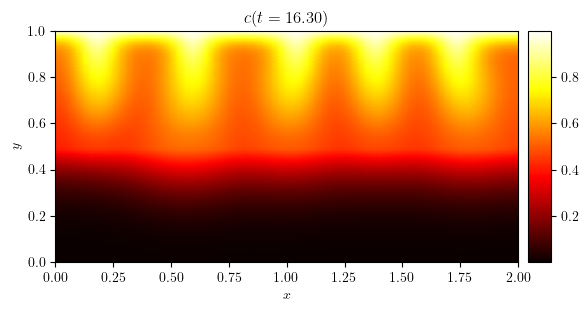

In [ ]:
c = simulation_layer['c']

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'$c(t={c.time_series[i]:.2f})$')
    write(fig, f'A12_layer_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)

### Example: high-resolution video

In [ ]:
simulation_highres = anisotropic_convection_2d(
    Lx=2.0,
    Ly=1.0,
    Ra=1e3,
    Nx=150,
    Ny=150,
    dt_max=0.1,
    D_adv=(AB2, CN),
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 10
integrate(simulation_highres, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

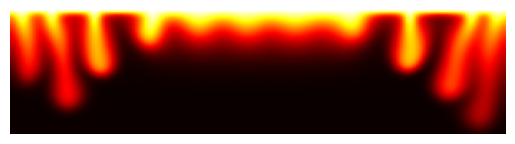

In [6]:
c = simulation_highres['c']

time_index = -1
fig, ax = plot_colormap(c.series[time_index], colorbar=False)
ax.set_ylim(0.5, 1)
ax.axis('off')
write(fig, f'A12_convection_onset_highres', './figures', file_ext='png', dpi=500, close=False, pickle=False)

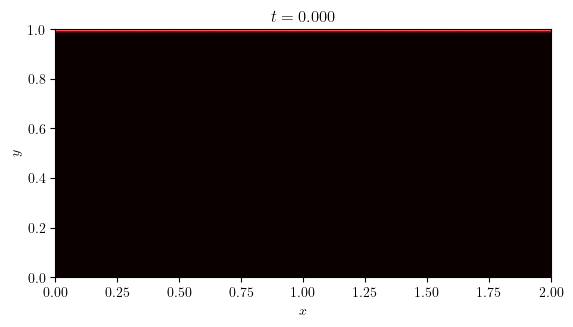

In [4]:
slc = slice(0, None, 2)

titles = [f'$t={t:.3f}$' for t in c.time_series[slc]]
colorbars = [False] * len(titles)

anim = create_animation(
    plot_colormap,
)(c.series[slc], title=titles, colorbar=colorbars)
write(anim, 'A12_convection_onset_highres', './figures')